# Tools for visualizing data

This notebook is a "tour" of just a few of the data visualization capabilities available to you in Python. It focuses on two packages: [Bokeh](https://blog.modeanalytics.com/python-data-visualization-libraries/) for creating _interactive_ plots and _[Seaborn]_ for creating "static" (or non-interactive) plots. The former is really where the ability to develop _programmatic_ visualizations, that is, code that generates graphics, really shines. But the latter is important in printed materials and reports. So, both techniques should be a core part of your toolbox.

With that, let's get started!

> **Note 1.** Since visualizations are not amenable to autograding, this notebook is more of a demo of what you can do. It doesn't require you to write any code on your own. However, we strongly encourage you to spend some time experimenting with the basic methods here and generate some variations on your own. Once you start, you'll find it's more than a little fun!
>
> **Note 2.** Though designed for R programs, Hadley Wickham has an [excellent description of many of the principles in this notebook](http://r4ds.had.co.nz/data-visualisation.html).

## Part 0: Downloading some data to visualize

For the demos in this notebook, we'll need the Iris dataset. The following code cell downloads it for you.

In [1]:
import requests
import os
import hashlib
import io

def download(file, url_suffix=None, checksum=None):
    if url_suffix is None:
        url_suffix = file
        
    if not os.path.exists(file):
        if os.path.exists('.voc'):
            url = 'https://cse6040.gatech.edu/datasets/{}'.format(url_suffix)
        else:
            url = 'https://github.com/cse6040/labs-fa17/raw/master/datasets/{}'.format(url_suffix)
        print("Downloading: {} ...".format(url))
        r = requests.get(url)
        with open(file, 'w', encoding=r.encoding) as f:
            f.write(r.text)
            
    if checksum is not None:
        with io.open(file, 'r', encoding='utf-8', errors='replace') as f:
            body = f.read()
            body_checksum = hashlib.md5(body.encode('utf-8')).hexdigest()
            assert body_checksum == checksum, \
                "Downloaded file '{}' has incorrect checksum: '{}' instead of '{}'".format(file, body_checksum, checksum)
    
    print("'{}' is ready!".format(file))
    
datasets = {'iris.csv': ('tidy', 'd1175c032e1042bec7f974c91e4a65ae'),
            'tips.csv': ('seaborn-data', 'ee24adf668f8946d4b00d3e28e470c82'),
            'anscombe.csv': ('seaborn-data', '2c824795f5d51593ca7d660986aefb87'),
            'titanic.csv': ('seaborn-data', '56f29cc0b807cb970a914ed075227f94')
           }

for filename, (category, checksum) in datasets.items():
    download(filename, url_suffix='{}/{}'.format(category, filename), checksum=checksum)
    
print("\n(All data appears to be ready.)")

'iris.csv' is ready!
'tips.csv' is ready!
'titanic.csv' is ready!
'anscombe.csv' is ready!

(All data appears to be ready.)


# Part 1: Bokeh and the Grammar of Graphics ("lite")

Let's start with some methods for creating an interactive visualization in Python and Jupyter, based on the [Bokeh](https://bokeh.pydata.org/en/latest/) package. The design and use of Bokeh is based on Leland Wilkinson's Grammar of Graphics (GoG).

> If you've encountered GoG ideas before, it was probably when using the best known implementation of GoG, namely, Hadley Wickham's R package, [ggplot2](http://ggplot2.org/).

## Setup

Here are the modules we'll need for this notebook:

In [2]:
from IPython.display import display, Markdown
import pandas as pd
import bokeh

Bokeh is designed to output HTML, which you can then embed in any website. To embed Bokeh output into a Jupyter notebook, we need to do the following:

In [3]:
from bokeh.io import output_notebook
from bokeh.io import show
output_notebook ()

Loading BokehJS ...

## Philosophy: Grammar of Graphics

[The Grammar of Graphics](http://www.springer.com.prx.library.gatech.edu/us/book/9780387245447) is an idea of Leland Wilkinson. Its basic idea is that the way most people think about visualizing data is ad hoc and unsystematic, whereas there exists in fact a "formal language" for describing visual displays.

The reason why this idea is important and powerful in the context of our course is that it makes visualization more systematic, thereby making it easier to create those visualizations through code.

The high-level concept is simple:
1. Start with a (tidy) data set.
2. Transform it into a new (tidy) data set.
3. Map variables to geometric objects (e.g., bars, points, lines) or other aesthetic "flourishes" (e.g., color).
4. Rescale or transform the visual coordinate system.
5. Render and enjoy!

![From data to visualization](http://r4ds.had.co.nz/images/visualization-grammar-3.png)

> This image is "liberated" from: http://r4ds.had.co.nz/data-visualisation.html

## (High-Level) Charts

The easiest way to use Bokeh is to call its interface for "canned" charts. For instance, let's load the Iris data set and study relationships among its variables, such as petal length vs. petal width.

The cells below demonstrate histograms, simple scatter plots, and box plots. However, there is a much larger gallery of options: http://bokeh.pydata.org/en/latest/docs/user_guide/charts.html

In [4]:
flora = pd.read_csv ('iris.csv')
display (flora.head ())

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
from bkcharts import Histogram, Scatter, BoxPlot
from bokeh.io import show

### 1. Histogram

* The Histogram(df, c) function can take a Pandas data frame df as input and refer to the aggregation variable, c, by column name.
* The plot is interactive and comes with a bunch of tools. You can customize these tools as well; for your many options, see http://bokeh.pydata.org/en/latest/docs/user_guide/tools.html.

In [6]:
p = Histogram(flora,'petal width', width =500, height = 500)
show(p)

A user can interact with the chart above using the tools shown on the right-hand side. Indeed, you can select or customize these tools! You'll see an example below.

### 2. ScatterPlot

In [7]:
p = Scatter(flora, x='petal width', y='sepal length')
show(p)

### 3. BoxPlot

In [8]:
p = BoxPlot(flora, values='sepal length', label='petal width')
show (p)

## Mid-level charts: the Plotting interface

Beyond the canned methods above, Bokeh provides a "mid-level" interface that more directly exposes the grammar of graphics methodology for constructing visual displays.

The basic procedure is 
* Create a blank canvas by calling `bokeh.plotting.figure`
* Add glyphs, which are geometric shapes.

> For a full list of glyphs, refer to the methods of `bokeh.plotting.figure`: http://bokeh.pydata.org/en/latest/docs/reference/plotting.html

In [9]:
from bokeh.plotting import figure

# Create a canvas with a specific set of tools for the user:
TOOLS = 'resize,pan,box_zoom,wheel_zoom,lasso_select,save,reset,help'
p = figure(width=500, height=500, tools=TOOLS)
print(p)

Figure(id='437bdaa4-8586-4850-9d29-757831b07a3b', ...)


In [10]:
# Add one or more glyphs
p.triangle(x=flora['petal width'], y=flora['petal length'])

GlyphRenderer(id='e13a6d4e-15aa-48c2-b934-94e8ed5b4820', ...)

In [11]:
show(p)

**Using data from Pandas.** Here is another way to do the same thing, but using a Pandas data frame as input.

In [12]:
from bokeh.models import ColumnDataSource

data=ColumnDataSource(flora)
p=figure()
p.triangle(source=data, x='petal width', y='petal length')
show(p)

**Color maps.** Let's make a map that assigns each unique species its own color. Incidentally, there are many choices of colors! http://bokeh.pydata.org/en/latest/docs/reference/palettes.html

In [13]:
# Determine the unique species
unique_species = flora['species'].unique()
print(unique_species)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [14]:
# Map each species with a unique color
from bokeh.palettes import brewer
color_map = dict(zip(unique_species, brewer['Dark2'][len(unique_species)]))
print(color_map)

{'Iris-versicolor': '#d95f02', 'Iris-setosa': '#1b9e77', 'Iris-virginica': '#7570b3'}


In [15]:
# Create data sources for each species
data_sources = {}
for s in unique_species:
    data_sources[s] = ColumnDataSource(flora[flora['species']==s])

Now we can more programmatically generate the same plot as above, but use a unique color for each species.

In [16]:
p = figure()
for s in unique_species:
    p.triangle(source=data_sources[s], x='petal width', y='petal length', color=color_map[s])
show(p)

That's just a quick tour of what you can do with Bokeh. We will incorporate it into some of our future labs. At this point, we'd encourage you to experiment with the code cells above and try generating your own variations!

# Part 2: Static visualizations using Seaborn

Parts of this lab are taken from publicly available Seaborn tutorials.
http://seaborn.pydata.org/tutorial/distributions.html

They were adapted for use in this notebook by [Shang-Tse Chen at Georgia Tech](https://www.cc.gatech.edu/~schen351).

In [17]:
import seaborn as sns

# The following Jupyter "magic" command forces plots to appear inline
# within the notebook.
%matplotlib inline

When dealing with a set of data, often the first thing we want to do is get a sense for how the variables are distributed. Here, we will look at some of the tools in seborn for examining univariate and bivariate distributions.

### Plotting univariate distributions
 distplot() function will draw a histogram and fit a kernel density estimate

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


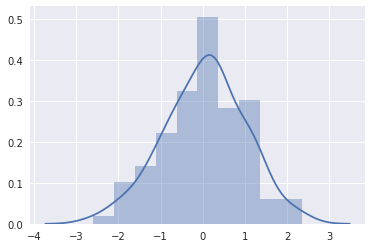

In [18]:
import numpy as np
x = np.random.normal(size=100)
sns.distplot(x)

## Plotting bivariate distributions

The easiest way to visualize a bivariate distribution in seaborn is to use the jointplot() function, which creates a multi-panel figure that shows both the bivariate (or joint) relationship between two variables along with the univariate (or marginal) distribution of each on separate axes.

In [19]:
mean, cov = [0, 1], [(1, .5), (.5, 1)]
data = np.random.multivariate_normal(mean, cov, 200)
df = pd.DataFrame(data, columns=["x", "y"])

**Basic scatter plots.** The most familiar way to visualize a bivariate distribution is a scatterplot, where each observation is shown with point at the x and y values. You can draw a scatterplot with the matplotlib plt.scatter function, and it is also the default kind of plot shown by the jointplot() function:

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


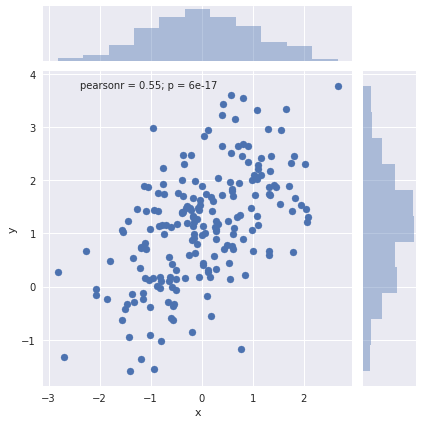

In [20]:
sns.jointplot(x="x", y="y", data=df)

**Hexbin plots.** The bivariate analogue of a histogram is known as a “hexbin” plot, because it shows the counts of observations that fall within hexagonal bins. This plot works best with relatively large datasets. It’s availible through the matplotlib plt.hexbin function and as a style in jointplot()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


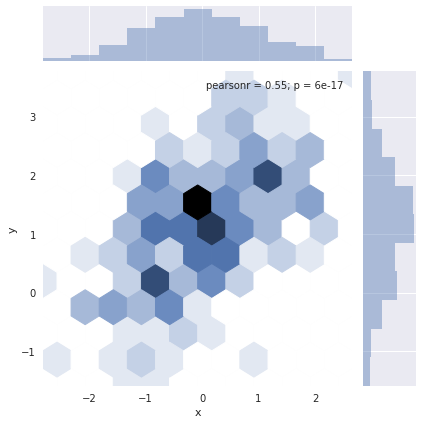

In [21]:
sns.jointplot(x="x", y="y", data=df, kind="hex")

**Kernel density estimation.** It is also posible to use the kernel density estimation procedure described above to visualize a bivariate distribution. In seaborn, this kind of plot is shown with a contour plot and is available as a style in jointplot()

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


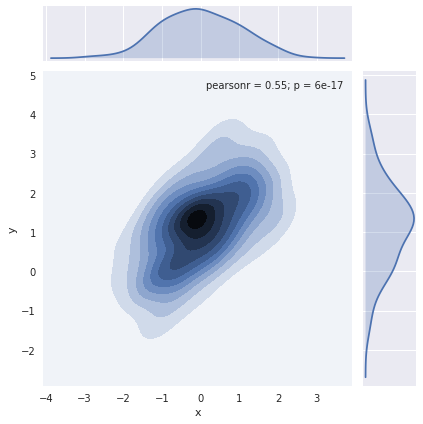

In [22]:
sns.jointplot(x="x", y="y", data=df, kind="kde")

## Visualizing pairwise relationships in a dataset
To plot multiple pairwise bivariate distributions in a dataset, you can use the pairplot() function. This creates a matrix of axes and shows the relationship for each pair of columns in a DataFrame. by default, it also draws the univariate distribution of each variable on the diagonal Axes:

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


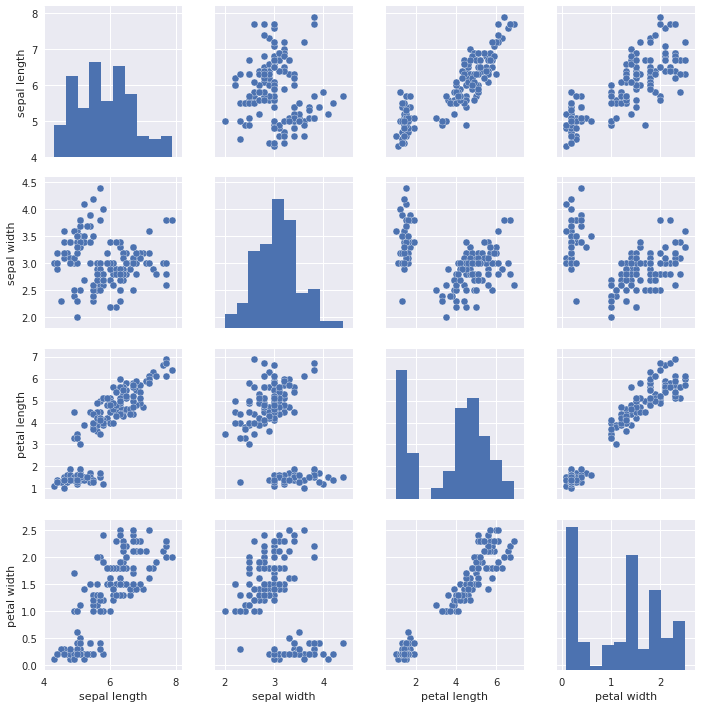

In [23]:
sns.pairplot(flora)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


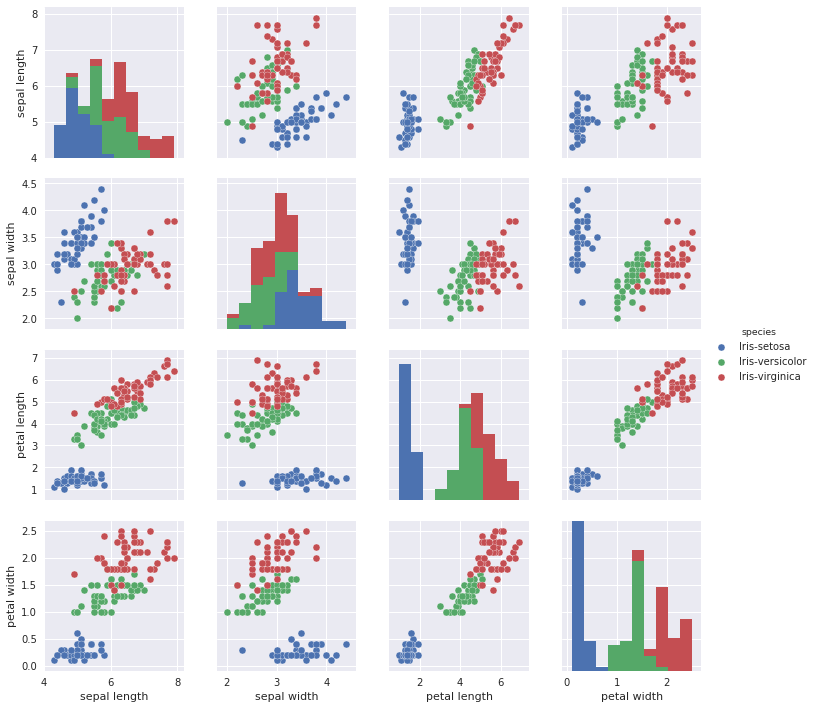

In [24]:
# We can add colors to different species
sns.pairplot(flora, hue="species")

### Visualizing linear relationships

In [25]:
tips = pd.read_csv("tips.csv")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


We can use the function `regplot` to show the linear relationship between total_bill and tip. 
It also shows the 95% confidence interval.

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


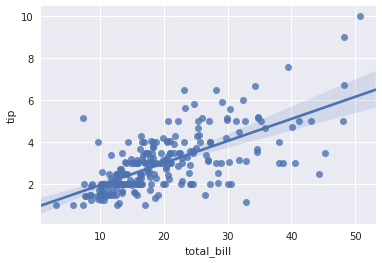

In [26]:
sns.regplot(x="total_bill", y="tip", data=tips)

### Visualizing higher order relationships

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


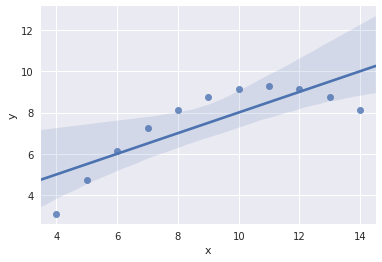

In [27]:
anscombe = pd.read_csv("anscombe.csv")
sns.regplot(x="x", y="y", data=anscombe[anscombe["dataset"] == "II"])

The plot clearly shows that this is not a good model.
Let's try to fit a polynomial regression model with degree 2.

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


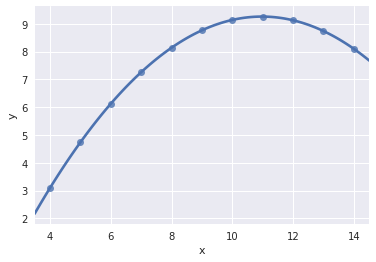

In [28]:
sns.regplot(x="x", y="y", data=anscombe[anscombe["dataset"] == "II"], order=2)

**Strip plots.** This is similar to scatter plot but used when one variable is categorical.

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


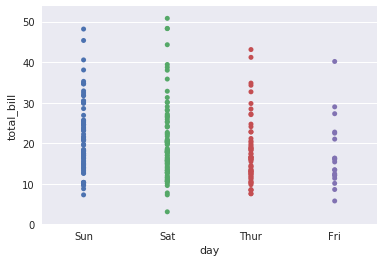

In [29]:
sns.stripplot(x="day", y="total_bill", data=tips)

**Box plots.**

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


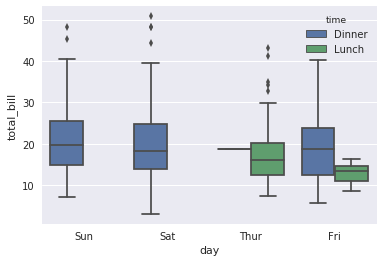

In [30]:
sns.boxplot(x="day", y="total_bill", hue="time", data=tips)

**Bar plots.**

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


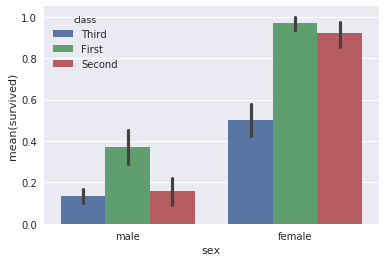

In [31]:
titanic = pd.read_csv("titanic.csv")
sns.barplot(x="sex", y="survived", hue="class", data=titanic)

**Fin!** That ends this tour of basic plotting functionality available to you in Python. It only scratches the surface of what is possible. We'll explore more advanced features in future labs, but in the meantime, we encourage you to play with the code in this notebook and try to generate your own visualizations of datasets you care about!

Although this notebook did not require you to write any code, go ahead and "submit" it for grading. You'll effectively get "free points" for doing so: the code cell below gives it to you.

In [32]:
# Test cell: `freebie_test`
assert True